In [1]:
import sys,os
sys.path.append('../')
from deep_rl import *
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import trange, tqdm
import random
import numpy as np
import pickle

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [5]:
def avdsr_feature(**kwargs):
    kwargs['tag'] = 'Training avDSR based on DQN agents'
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.002)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), hidden_units=(), config=0) #CHECK
#     config.network_fn = lambda: SRNetCNN(config.action_dim, SRIdentityBody(config.state_dim), 
#                                          hidden_units=(2000,), config=0)
    config.replay_fn = lambda: Replay(memory_size=int(4e5), batch_size=10)

    config.random_action_prob = LinearSchedule(1, 1, 1e4) # CHECK
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.max_steps = 3e5
    config.async_actor = False
    
    agent = avDSRAgent(config, config.agents, style='DQN')
    return agent
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.log_interval and not agent.total_steps % config.log_interval:
            agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()

In [6]:
avdsr = avdsr_feature(game='FourRoomsMatrixNoTerm', agents=[], choice=0)

In [32]:
weights = torch.load('../storage/01-avdsr.weights', map_location='cpu').state_dict()
avdsr.network.load_state_dict(weights,strict=True)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

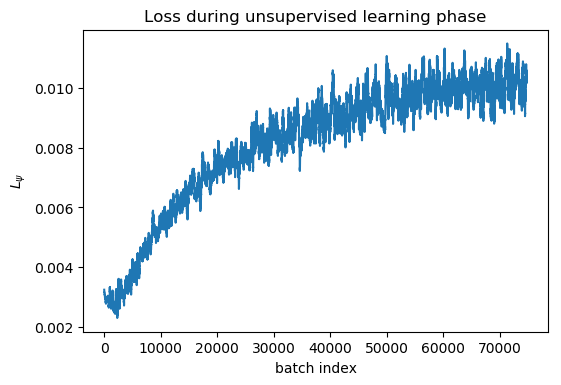

In [39]:
with open('../storage/01-loss.p', 'rb') as f:
    loss_vec = pickle.load(f)
kernel = 200
plt.figure(figsize=(6,4), dpi=100)
plt.plot(convolve(loss_vec, kernel))
plt.title('Loss during unsupervised learning phase') 
plt.xlabel('batch index'), plt.ylabel('$L_\psi$')
plt.show()

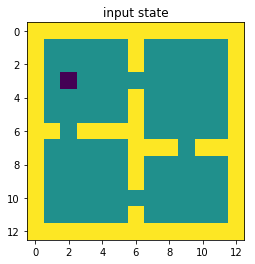

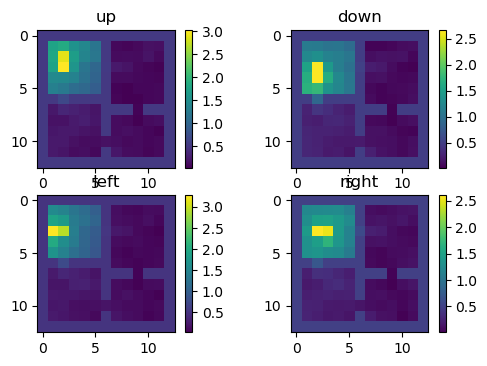

In [45]:
from deep_rl.component.fourrooms import *
g = [21, 28, 84, 91]
env = FourRoomsMatrix(layout='4rooms')
state = env.reset(init=g[0])
# env = FourRoomsMatrix(layout='3rooms')
# state = env.reset(init=40)
# env.current_cell = (3,2)
# state, _, _, _ = env.step(env.action_space.sample())
plt.imshow(env.render(show_goal=False)); plt.title('input state'), plt.show()
_, out, _ = avdsr.network(tensor(state).unsqueeze(0))
# plt.imshow(state.reshape((13,13))), plt.show()

dirs = {0: 'up', 1: 'down', 2:'left', 3:'right'}

plt.figure(dpi=100)
psi = out.detach().cpu().numpy()
for i in range(4):
    psi_a = psi[0,i,:]
    plt.subplot(2,2,i+1)
    plt.imshow(psi_a.reshape((13,13)))
    plt.title(dirs[i])
    plt.colorbar()

plt.show()


Text(0.5,1,'Plotting principle components of psi using PCA')

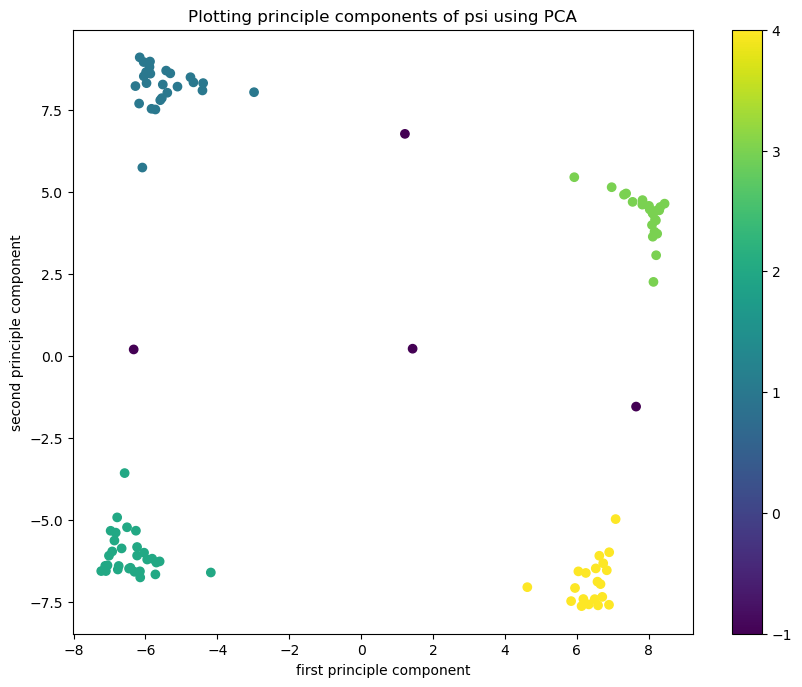

In [41]:
from deep_rl.component.fourrooms import *
g = [21, 28, 84, 91]
c = np.ones(104)*4
room1 = list(range(5)) + list(range(10,15)) + list(range(20,25)) + list(range(31,36)) +list(range(41,46))
room2 = list(range(5,10)) + list(range(15,20)) + list(range(26,31)) + list(range(36,41)) + list(range(46,51)) + list(range(52,57))
room3 = list(range(57,62)) + list(range(63,68)) + list(range(73,78)) + list(range(83,88)) + list(range(94,99))
connect = [25, 51, 62, 88]
c[room1] = 1
c[room2] = 2
c[room3] = 3
c[connect] = [-1, -1, -1, -1]
env = FourRoomsMatrix(layout='4rooms')
psi_all = np.zeros((104,169*4))
for i in range(104):
    state = env.reset(init=i)
    _, out, _ = avdsr.network(tensor(state).unsqueeze(0))
    psi = out.detach().cpu().numpy()
    psi_all[i,:] = psi.flatten()

psi_all.shape

from sklearn.decomposition import PCA
plt.figure(figsize=(10,8),dpi=100)
pca = PCA(n_components=2)
k = pca.fit_transform(psi_all)
plt.scatter(k[:,0],k[:,1], c=c)
plt.xlabel('first principle component'), plt.ylabel('second principle component')
plt.colorbar()
plt.title('Plotting principle components of psi using PCA')

In [ ]:


def dimenRed(vis_agent):
    """
    Function to reduce the dimensionality of the psi(s,a) representations learnt,
    and visualizing them.
    """
    state_space = np.identity(104)
    c = np.ones(104)*4
    room1 = list(range(5)) + list(range(10,15)) + list(range(20,25)) + list(range(31,36)) +list(range(41,46))
    room2 = list(range(5,10)) + list(range(15,20)) + list(range(26,31)) + list(range(36,41)) + list(range(46,51)) + list(range(52,57))
    room3 = list(range(57,62)) + list(range(63,68)) + list(range(73,78)) + list(range(83,88)) + list(range(94,99))
    connect = [25, 51, 62, 88]
    c[room1] = 1
    c[room2] = 2
    c[room3] = 3
    c[connect] = [-1, -1, -1, -1]
    
    _, psi, _ = vis_agent.network(tensor(state_space))
    psi = psi.view(104,-1).detach().numpy()
    pca = PCA(n_components=2)
    k = pca.fit_transform(psi)
    print(k.shape)
    plt.scatter(k[:,0],k[:,1],c=c)
    plt.colorbar()
    plt.title('Plotting principle components of psi')
    
    
def dimenRed2(vis_agent, act_agent):
    """
    Function to reduce the dimensionality of the psi* representations learnt,
    and visualizing them.
    NOTE: psi*, where are the optimal actions picked from matters. act_agent 
    is used here.
    """
    state_space = np.identity(104)
    
    _, psi, _ = vis_agent.network(tensor(state_space))
    
    if('DSR' in str(type(act_agent))):
        _, _, q = act_agent.network(tensor(state_space))
    else:
        q = act_agent.network(tensor(state_space))
    optimal_actions = q.max(1)[1].detach().numpy()
    
    pass

dimenRed(avdsr)

In [ ]:
from deep_rl.component.fourrooms import *
env = FourRoomsMatrix(layout='3rooms')
g = [21, 28, 84, 91]
state = env.reset(init=40)
# env.current_cell = (3,2)
# state, _, _, _ = env.step(env.action_space.sample())
plt.imshow(env.render()); plt.title('input state'), plt.show()
_, out, _ = avdsr.network(tensor(state).unsqueeze(0))
# plt.imshow(state.reshape((13,13))), plt.show()

dirs = {0: 'up', 1: 'down', 2:'left', 3:'right'}

plt.figure(dpi=100)
psi = out.detach().cpu().numpy()
for i in range(4):
    psi_a = psi[0,i,:]
    plt.subplot(2,2,i+1)
    plt.imshow(psi_a.reshape((13,13)))
    plt.title(dirs[i])
    plt.colorbar()

plt.show()

In [47]:
avdsr = avdsr_feature(game='FourRoomsMatrixNoTerm', agents=[], choice=0)
weights = torch.load('../storage/15-300000-avdsr.weights', map_location='cpu').state_dict()
avdsr.network.load_state_dict(weights,strict=True)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [44]:
avdsr.network

SRNetCNN(
  (body): SRIdentityBody()
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (layers): ModuleList(
    (0): Linear(in_features=2048, out_features=2000, bias=True)
    (1): Linear(in_features=2000, out_features=676, bias=True)
  )
  (psi2q): Psi2QNet()
)